# Bike Sharing Analysis with Ford GoBike Data
## by Mitesh Kavaiya


> Bicycle-sharing systems allow users to rent bicycles for short trips. With the information technologies, it is easy for a user of the system to access a dock within the system to unlock or return bicycles. These technologies also provide a wealth of data that can be used to explore how these bike-sharing systems are used.  In this project, I will perform an investigative analysis on data provided by Ford GoBike, a bike-share system provider.

## Preliminary Wrangling
>we will focus on the record of individual trips taken in from 2017 to May 6th 2019.

Ford GoBike Data: https://s3.amazonaws.com/fordgobike-data/index.html


In [6]:
# import all packages and set plots to be embedded inline
from requests import get
from os import path, getcwd, makedirs, listdir 
from io import BytesIO
from zipfile import ZipFile

import numpy as np
import pandas as pd
import matplotlib

from matplotlib import pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import datetime
import math
import calendar
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image


%matplotlib inline

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

In [7]:
# download the dataset with pandas
folder_name_of_csvs = 'trip_data_files'

In [89]:
makedirs(folder_name_of_csvs)
pd.read_csv('https://s3.amazonaws.com/fordgobike-data/2017-fordgobike-tripdata.csv').to_csv('{}/2017-forgobike-tripdata.csv'.format(folder_name_of_csvs))
for month in range(1,5):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2)
    
    bike_data_url = 'https://s3.amazonaws.com/fordgobike-data/2019' + month_leading_zero + '-fordgobike-tripdata.csv.zip'
    response = get(bike_data_url)
        
    # code below opens zip file; BytesIO returns a readable and writeable view of the contents;
    unzipped_file = ZipFile(BytesIO(response.content))
        
    # puts extracted zip file into folder trip_data_files
    unzipped_file.extractall(folder_name_of_csvs)

In [115]:
# download the dataset with pandas
folder_name_of_csvs = 'trip_data_files'

In [117]:
for month in range(1,13):
    month_string = str(month)
    month_leading_zero = month_string.zfill(2)
    
    bike_data_url = 'https://s3.amazonaws.com/fordgobike-data/2018' + month_leading_zero + '-fordgobike-tripdata.csv.zip'
    response = get(bike_data_url)
        
    # code below opens zip file; BytesIO returns a readable and writeable view of the contents;
    unzipped_file = ZipFile(BytesIO(response.content))
        
    # puts extracted zip file into folder trip_data_files
    unzipped_file.extractall(folder_name_of_csvs)

In [118]:
# Combine All Locally Saved CSVs into One DataFrame
list_csvs = []
for file_name in listdir(folder_name_of_csvs):
    list_csvs.append(pd.read_csv(folder_name_of_csvs+'/'+file_name))
df = pd.concat(list_csvs)


In [119]:
df.to_csv('data.csv')

In [120]:
# Examine DataFrame
df = pd.read_csv('data.csv')

In [121]:
len(df)

3254325

In [123]:
#Set visualization style
sns.set_style('whitegrid')
sns.set_context("talk")

In [124]:
#Filter data to include reasonable member age range
df['member_age'] = 2018-df['member_birth_year']

In [125]:
# Check age distrubition
df['member_age'].describe(percentiles = [.1, .2, .3, .4, .5, .6, .7, .75, .8, .9, .95])

count    3.036159e+06
mean     3.486325e+01
std      1.043760e+01
min      1.700000e+01
10%      2.400000e+01
20%      2.600000e+01
30%      2.900000e+01
40%      3.000000e+01
50%      3.300000e+01
60%      3.500000e+01
70%      3.800000e+01
75%      4.000000e+01
80%      4.300000e+01
90%      5.000000e+01
95%      5.500000e+01
max      1.400000e+02
Name: member_age, dtype: float64

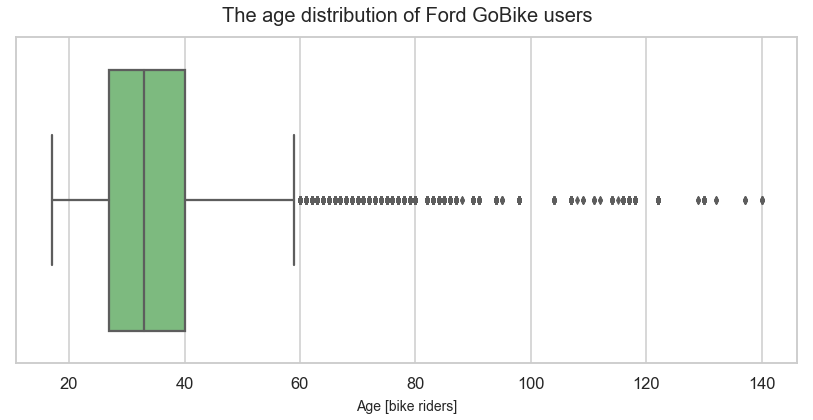

In [126]:
plt.figure(figsize=(14,6))
sns.boxplot(x='member_age', data=df, palette='Greens', orient='h')
plt.title("The age distribution of Ford GoBike users", fontsize=20, y=1.03)
plt.xlabel("Age [bike riders]", fontsize=14, labelpad=8)
plt.savefig('image01.png');

#Ages from 18 to 56 takes 95% of the users. There are users more than 100 years old. We can remove users more than 60 years old.

In [127]:
df = df[df['member_age']<=60]

In [128]:
df['member_age'].mean()

34.16882305608743

In [129]:
df.drop(['Unnamed: 0', 'member_birth_year'], axis=1, inplace=True)

In [130]:
#Filter data only to include San Francisco rides
max_longitude_sf = -122.3597
min_longitude_sf = -122.5147
max_latitude_sf = 37.8121
min_latitude_sf = 37.7092

In [131]:
end_station_latitude_mask = (df['end_station_latitude']>=min_latitude_sf) & (df['end_station_latitude']<=max_latitude_sf)
start_station_latitude_mask = (df['start_station_latitude']>=min_latitude_sf) & (df['start_station_latitude']<=max_latitude_sf)

In [132]:
end_station_longitude_mask =(df['end_station_longitude']>=min_longitude_sf) & (df['end_station_longitude']<=max_longitude_sf)
start_station_longitude_mask = (df['start_station_longitude']>=min_longitude_sf) & (df['start_station_longitude']<=max_longitude_sf)

In [133]:
df = df[end_station_latitude_mask & start_station_latitude_mask & end_station_longitude_mask & start_station_longitude_mask]

In [134]:
len(df)

2196027

#### Now the datasize became 2.1 million from 3.2 million.

In [135]:
# high-level overview of data shape and composition
print(df.shape)
print(df.dtypes)
print(df.head(10))

(2196027, 17)
Unnamed: 0.1               float64
bike_id                      int64
bike_share_for_all_trip     object
duration_sec                 int64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
end_station_name            object
end_time                    object
member_gender               object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
start_station_name          object
start_time                  object
user_type                   object
member_age                 float64
dtype: object
    Unnamed: 0.1  bike_id bike_share_for_all_trip  duration_sec  \
0            0.0       96                     NaN         80110   
1            1.0       88                     NaN         78800   
12          12.0     2311                     NaN          2183   
13          13.0     3717                     NaN          2170   
15          15.0      558                 

### What is the structure of your dataset?

> There are 2196027 rides in the dataset with features like bike_id, user_type, member_age, start_station_name etc. Most variables are numeric in the dataset.

### What is/are the main feature(s) of interest in your dataset?

> Average riding duration, Average riding distance, Leisure or to go far away, Age groups of users, Genders, Weekly day distrubition etc.,

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I think, gender, age group and purposer of use will be very useful.

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

In [136]:
#Generate new fields for date from start_time and end_time
df['start_time']=pd.to_datetime(df['start_time'])
df['end_time']=pd.to_datetime(df['end_time'])

In [137]:
df['start_time_date']=df['start_time'].dt.date
df['end_time_date']=df['end_time'].dt.date

In [138]:
df['start_time_year_month']=df['start_time'].map(lambda x: x.strftime('%Y-%m'))
df['end_time_year_month']=df['end_time'].map(lambda x: x.strftime('%Y-%m'))

In [139]:
df['start_time_year_month_renamed'] = df['start_time'].dt.strftime('%y' + '-' + '%m')

In [140]:
df['start_time_year']=df['start_time'].dt.year.astype(int)
df['end_time_year']=df['end_time'].dt.year.astype(int)

In [141]:
df['start_time_month']=df['start_time'].dt.month.astype(int)
df['end_time_month']=df['end_time'].dt.month.astype(int)

In [142]:
df['start_time_hour_minute']=df['start_time'].map(lambda x: x.strftime('%H-%m'))
df['end_time_hour_minute']=df['end_time'].map(lambda x: x.strftime('%H-%m'))

In [143]:
df['start_time_hour']=df['start_time'].dt.hour
df['end_time_hour']=df['end_time'].dt.hour

In [144]:
df['start_time_weekday']=df['start_time'].dt.weekday_name
df['end_time_weekday']=df['end_time'].dt.weekday_name

In [145]:
df['start_time_weekday_abbr']=df['start_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])
df['end_time_weekday_abbr']=df['end_time'].dt.weekday.apply(lambda x: calendar.day_abbr[x])

In [146]:
#Generate a new field for member age group from member_age_bin
df['member_age_bins'] = df['member_age'].apply(lambda x: '10 - 20' if 10<x<=20
                                                  else '20 - 30' if 20<x<=30
                                                  else '30 - 40' if 30<x<=40
                                                  else '40 - 50' if 40<x<=50
                                                  else '50 - 60' if 50<x<=60
                                                  else x)

In [147]:
#Generate minutes for trip duration from duration_sec
df['duration_min'] = df['duration_sec']/60

In [148]:
#Generate new fields for distance
def distance(origin, destination):
    """
    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d

In [149]:
df['distance_km_estimates'] = df.apply(lambda x: distance((x['start_station_latitude'], x['start_station_longitude']), (x['end_station_latitude'], x['end_station_longitude'])), axis=1)
df['distance_miles_estimates'] = df['distance_km_estimates']*0.621371

### Question 1. How is Ford GoBike growing?
Avg. count of rides/bike/day

I decided to select March in order to compare the data findings because it is in summer season.

In [152]:
count_of_rides = df.groupby('start_time_year_month_renamed')['bike_id'].size().reset_index()

In [153]:
count_of_unique_rides = df.groupby('start_time_year_month_renamed')['bike_id'].nunique().reset_index().rename(columns={'bike_id':'unique_bike_id'})

In [154]:
count_of_rides_df = count_of_rides.merge(count_of_unique_rides, on='start_time_year_month_renamed')

In [155]:
count_of_rides_df['number_of_used'] = count_of_rides_df['bike_id']/count_of_rides_df['unique_bike_id']

In [156]:
March2018_avg_num_bike_used_per_day = (count_of_rides_df[count_of_rides_df['start_time_year_month_renamed']=='18-03']['number_of_used'].mean())/31

In [157]:
March2019_avg_num_bike_used_per_day = (count_of_rides_df[count_of_rides_df['start_time_year_month_renamed']=='19-03']['number_of_used'].mean())/31

In [158]:
print(March2018_avg_num_bike_used_per_day, March2019_avg_num_bike_used_per_day)

1.5237834882449426 2.423805168389008


In [159]:
March2019_avg_num_bike_used_per_day/March2018_avg_num_bike_used_per_day

1.5906493193338698

Compared these two Winter and Summer months in different years, the average increased 1.5 times in March 2019 compared to March 2018, where average count of rides per bike per day reaches to (2.4238).

Count of daily bike rides from July 2017 to November 2018

In [150]:
def transform_axis_fmt(tick_val, pos):
    if tick_val >= 1000:
        val = int(tick_val/1000)
        return '{:d}K'.format(val)
    elif tick_val >= 1000000: 
        val = int(tick_val/1000000)
        return '{:d}M'.format(val)
    else:
        return int(tick_val)

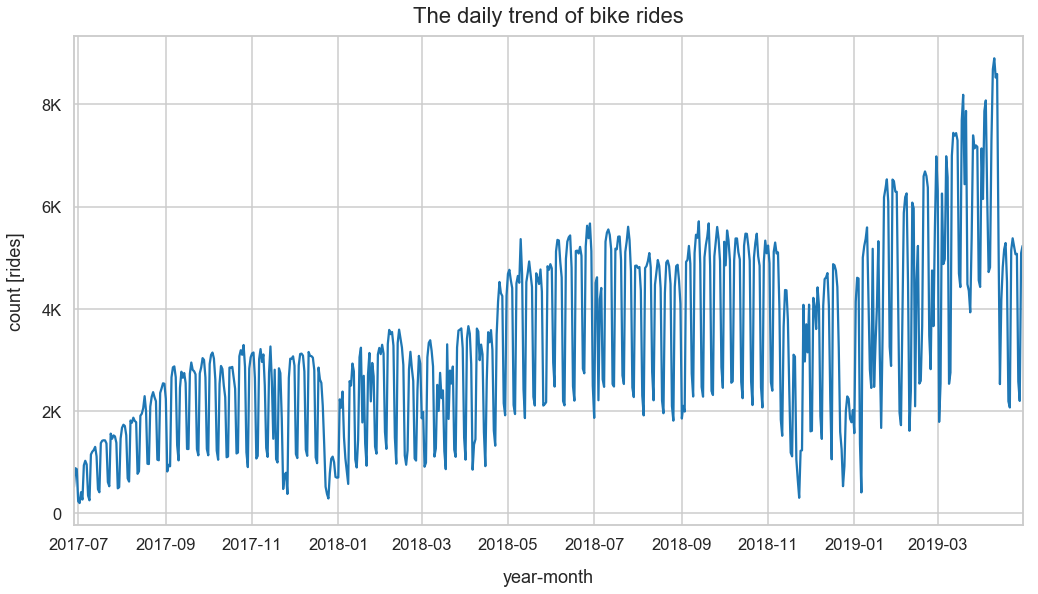

In [151]:
df.groupby('start_time_date').agg({'bike_id':'count'}).plot(style='-', legend=False, figsize=(17,9))
plt.title('The daily trend of bike rides', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image02.png');


Compared to begining of July 2017, where daily rides were less than 1K, it increased to more than 5000 after less than year (June 2018) There is huge decrease around winter months of November to January every year. March 2019 season is better compared to March 2018.

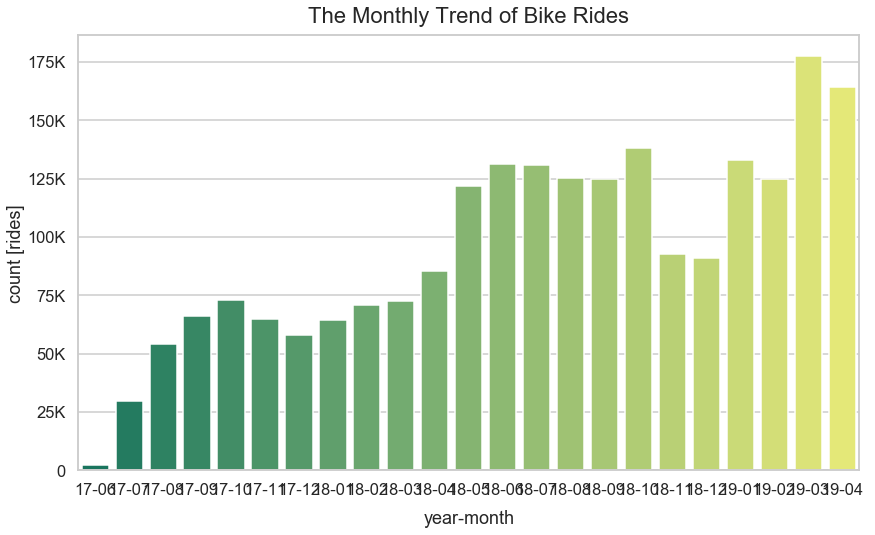

In [173]:
plt.figure(figsize=(14,8))
sns.countplot(x='start_time_year_month_renamed', palette="summer", data=df.sort_values(by='start_time_year_month_renamed'))
plt.title('The Monthly Trend of Bike Rides', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=12)
plt.ylabel('count [rides]', labelpad=2)
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image03.png')

Count of People Who took bike rides by Age Group Per Month

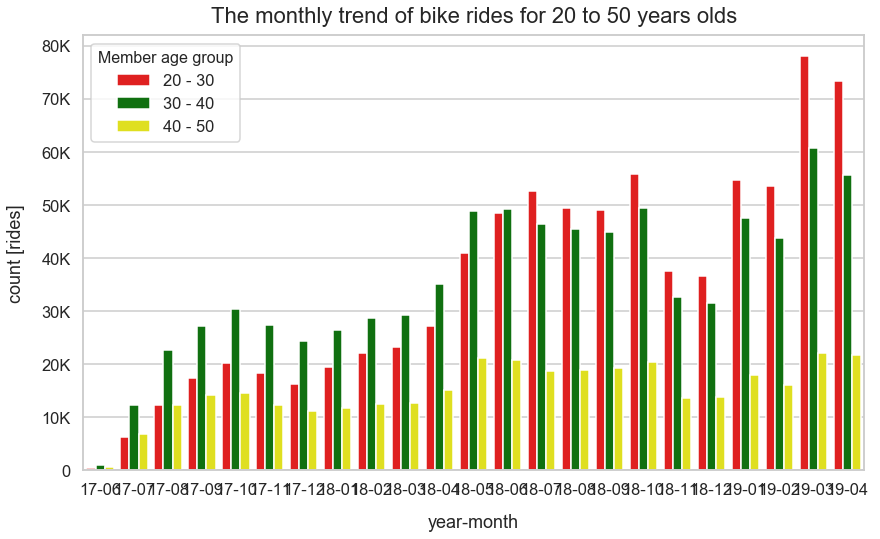

In [181]:
plt.figure(figsize=(14,8))
my_palette = {'20 - 30': 'red', '30 - 40': 'green', '40 - 50': 'yellow'}
ax = sns.countplot(x='start_time_year_month_renamed', hue='member_age_bins', palette=my_palette, data=df[df['member_age_bins'].isin(['20 - 30', '30 - 40', '40 - 50'])].sort_values(by=['start_time_year_month_renamed', 'member_age_bins']))
plt.title('The monthly trend of bike rides for 20 to 50 years olds', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('Member age group',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image04.png');

20-30 years and 30-40 old users are rapidly growing compared to other user groups. When the service first started 30-40 years old users were dominant, however 20-30 years old users became leader in almost 2 years.

### Question 2. How does rides trend change per age, gender, weekday, and hour of a day?

In [182]:
df['bike_id'].sum()

6254236146

There were 6.25 Billion rides.

Distrubition of bike rides vs user age group

In [184]:
trip_by_age_df = df.groupby('member_age_bins').agg({'bike_id':'count'})

In [185]:
trip_by_age_df['perc'] = (trip_by_age_df['bike_id']/trip_by_age_df['bike_id'].sum())*100

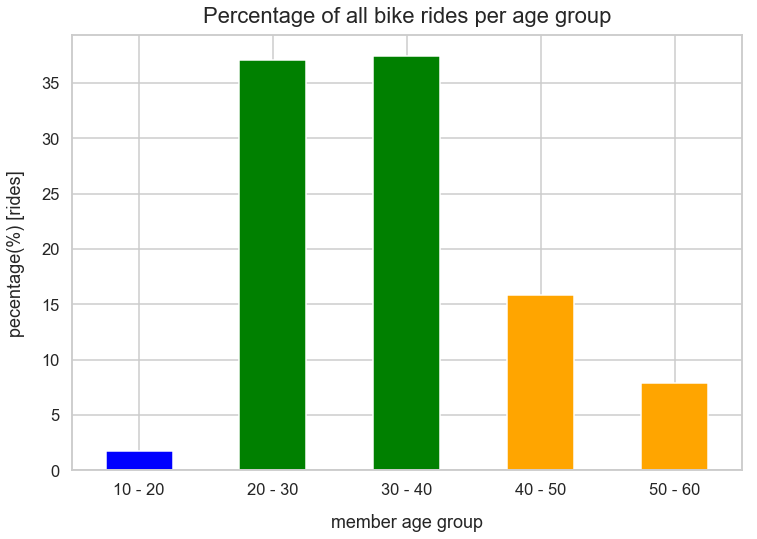

In [187]:
new_color = ['blue', 'green', 'green', 'Orange', 'orange']
trip_by_age_df['perc'].plot(kind='bar', color=new_color, figsize=(12,8))
plt.title('Percentage of all bike rides per age group', fontsize=22, y=1.015)
plt.xlabel('member age group', labelpad=16)
plt.ylabel('pecentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)
plt.savefig('image05.png');

20 to 40 years old people took the more than %70 of bike rides. Among those, 30 to 40 years old people's rides account almost %40 of all bike rides.

#### Bike rides per gender

In [189]:
trip_by_gender_df = df.groupby('member_gender').agg({'bike_id':'count'})

In [190]:
trip_by_gender_df['perc'] = (trip_by_gender_df['bike_id']/trip_by_gender_df['bike_id'].sum())*100

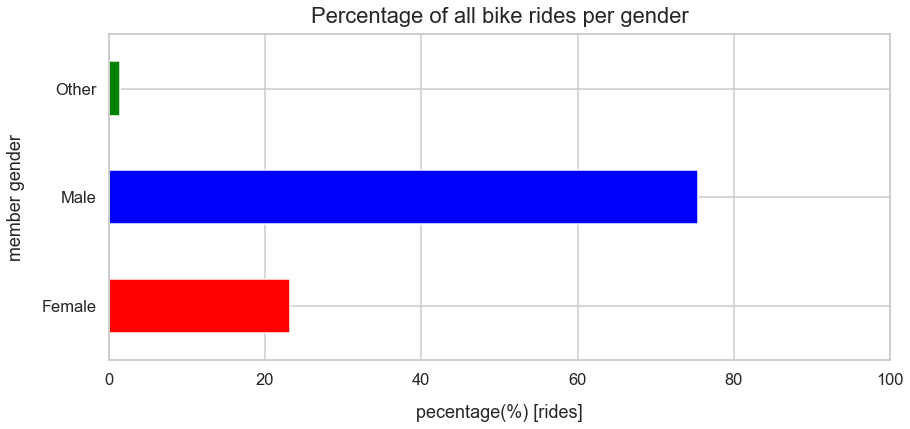

In [196]:
new_color = ['red', 'blue', 'green']
trip_by_gender_df['perc'].plot(kind='barh', color=new_color, figsize=(14,6))
plt.title('Percentage of all bike rides per gender', fontsize=22, y=1.015)
plt.ylabel('member gender', labelpad=16)
plt.xlabel('pecentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)
plt.xlim(0,100)
plt.savefig('image06.png');

Male took around %76 of all bike rides, and female took around %22 of them.

Bike rides per weekday

In [198]:
trip_by_weekday_df = df.groupby('start_time_weekday_abbr').agg({'bike_id':'count'})

In [199]:
trip_by_weekday_df['perc'] = (trip_by_weekday_df['bike_id']/trip_by_weekday_df['bike_id'].sum())*100

In [200]:
weekday_index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

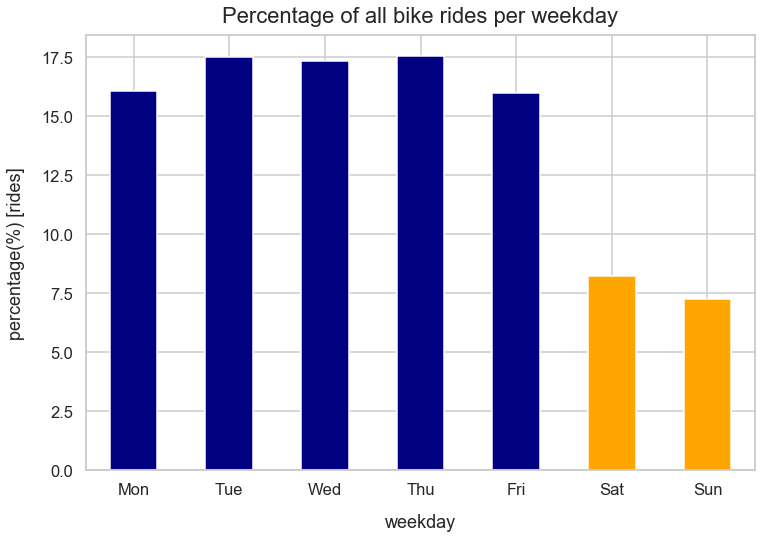

In [201]:
new_color = ['navy', 'navy', 'navy', 'navy', 'navy', 'Orange', 'orange']
trip_by_weekday_df.reindex(weekday_index)['perc'].plot(kind='bar', color=new_color, figsize=(12,8), legend=False)
plt.title('Percentage of all bike rides per weekday', fontsize=22, y=1.015)
plt.xlabel('weekday', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)
plt.xticks(rotation=360)
plt.savefig('image07.png');

People use this service on weekdays more than weekends.

Peak hours of the day

In [202]:
trip_by_hour_df = df.groupby('start_time_hour').agg({'bike_id':'count'}).reset_index()

In [203]:
trip_by_hour_df['bike_id'] = (trip_by_hour_df['bike_id']/trip_by_hour_df['bike_id'].sum())*100

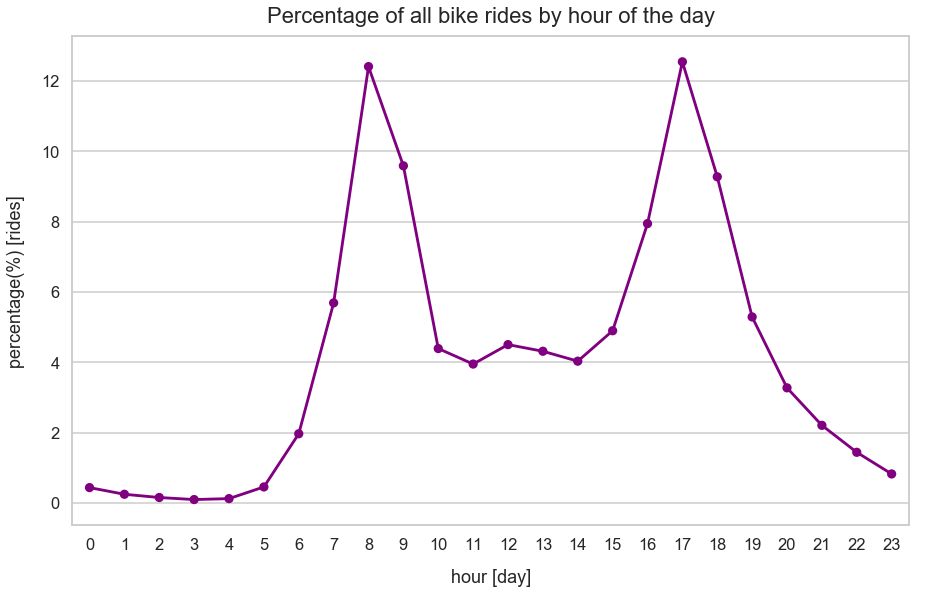

In [205]:
plt.figure(figsize=(15,9))
sns.pointplot(x='start_time_hour', y='bike_id', scale=.7, color='purple', data=trip_by_hour_df)
plt.title('Percentage of all bike rides by hour of the day', fontsize=22, y=1.015)
plt.xlabel('hour [day]', labelpad=16)
plt.ylabel('percentage(%) [rides]', labelpad=16)
plt.savefig('image08.png');


8am and 5pm are the peak hours for this service. Moreover, people use this service when they are in lunch time as well.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

I checked following variables one by one: Average rides, daily and monthly trend of riders, age groups, genders, weekdays or weekends comparision, peak hours, user types with distances etc. All these variables are important to understand the dataset and communicating the data findings at the end of this project.

There were 6.25 billion rides.  
20-30 years old users are rapidly growing compared to other user groups. When the service first started 30-40 years old users were dominant, however 20-30 years old users became leader in a year.

20 to 40 years old people took the more than %70 of bike rides. Among those, 30 to 40 years old people's rides account almost %40 of all bike rides.

Male took around %76 of all bike rides, and female took around %24 of them.
People use this service on weekdays more than weekends.
8am and 5pm are the peak hours for this service. Also, people use this service when they are in lunch time as well.


### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

I tidy up the data which contains member ages more than 60 years old. Ages from 18 to 56 takes 95% of the users. There were users more than 100 years old. Regarding this situation and results of age distribution, we can remove users more than 60 years old.

I generated new fields such as duration, time, age groups etc. to calculate them easily and understand the dataframe.
Ford GoBike avail the service to San Francisco, Oakland and San Jose. However, it's hard to imagine traffic. So regarding this complexity, I decided to focus on San Fancisco area by limiting with latitude and longitude.


## Bivariate Exploration

Question 3. Are there any difference between subscribers' and customers' behaviors?

Percentage of bike rides of subscribers vs customers

In [206]:
count_of_rides_per_user_type = df.groupby('user_type').size().reset_index(name='count')

In [207]:
count_of_rides_per_user_type['count']/len(df)*100

0    12.03906
1    87.96094
Name: count, dtype: float64

Percentage of subscribers is 12.03906

Percentage of customers is 87.96094

User trends of bike rides of subscribers vs customers

In [210]:
user_type_count_per_year_df = df.groupby(["start_time_year_month_renamed", "user_type"]).size().reset_index()

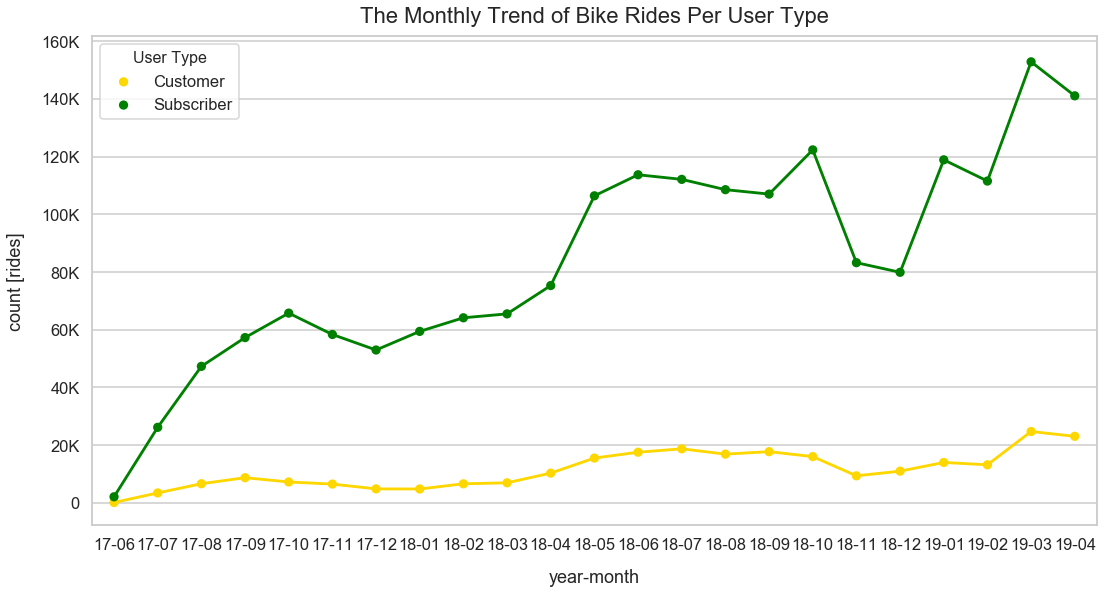

In [214]:
plt.figure(figsize=(18,9))
my_palette = {'Subscriber':'green', 'Customer':'gold'}
ax = sns.pointplot(x='start_time_year_month_renamed', y=0, hue='user_type', palette=my_palette, scale=.7, data=user_type_count_per_year_df)
plt.title('The Monthly Trend of Bike Rides Per User Type', fontsize=22, y=1.015)
plt.xlabel('year-month', labelpad=16)
plt.ylabel('count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('User Type',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image09.png');

Customers' rides seems increasing slightly. There is a decrease during winter months for subscribers. 

Average trip duration of subscribers vs customers

Text(0.5, 0, 'Minutes [trip duration]')

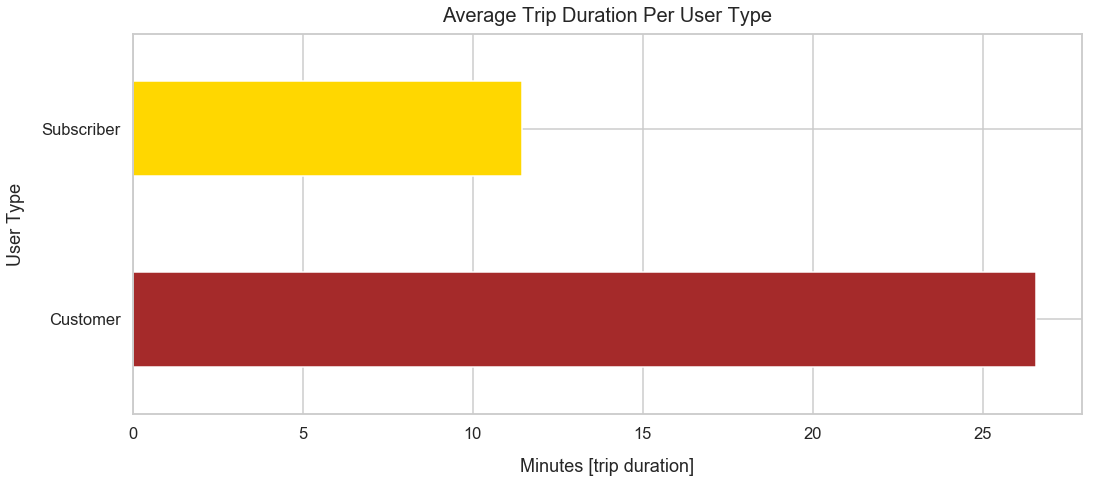

In [216]:
new_color=['brown', 'gold']
ax = df.groupby('user_type')['duration_min'].mean().plot(kind='barh', color=new_color, figsize=(17,7))
ax.set_title('Average Trip Duration Per User Type', fontsize=20, y=1.015)
ax.set_ylabel('User Type', labelpad=16)
ax.set_xlabel('Minutes [trip duration]', labelpad=16)

Subscribers' average trip duration is around 11 minutes.

Customers' average trip duration is around 28 minutes.

 #### Average trip distance of subscribers vs customers

Text(0.5, 0, 'Miles [distance]')

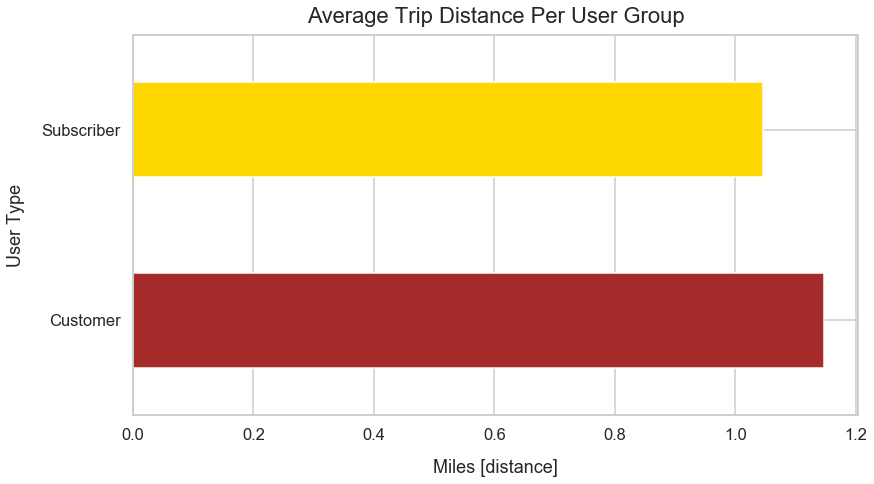

In [218]:
ax = df.groupby('user_type')['distance_miles_estimates'].mean().plot(kind='barh', color=new_color, figsize=(13,7))
ax.set_title('Average Trip Distance Per User Group', fontsize=22, y=1.015)
ax.set_ylabel('User Type', labelpad=16)
ax.set_xlabel('Miles [distance]', labelpad=16)

Subscribers and customers trip distance were about the same.

In [219]:
subscriber_age_df = df[df['user_type']=='Subscriber'].groupby(['start_time_year_month_renamed', 'member_age_bins']).agg({'bike_id':'count'}).reset_index()

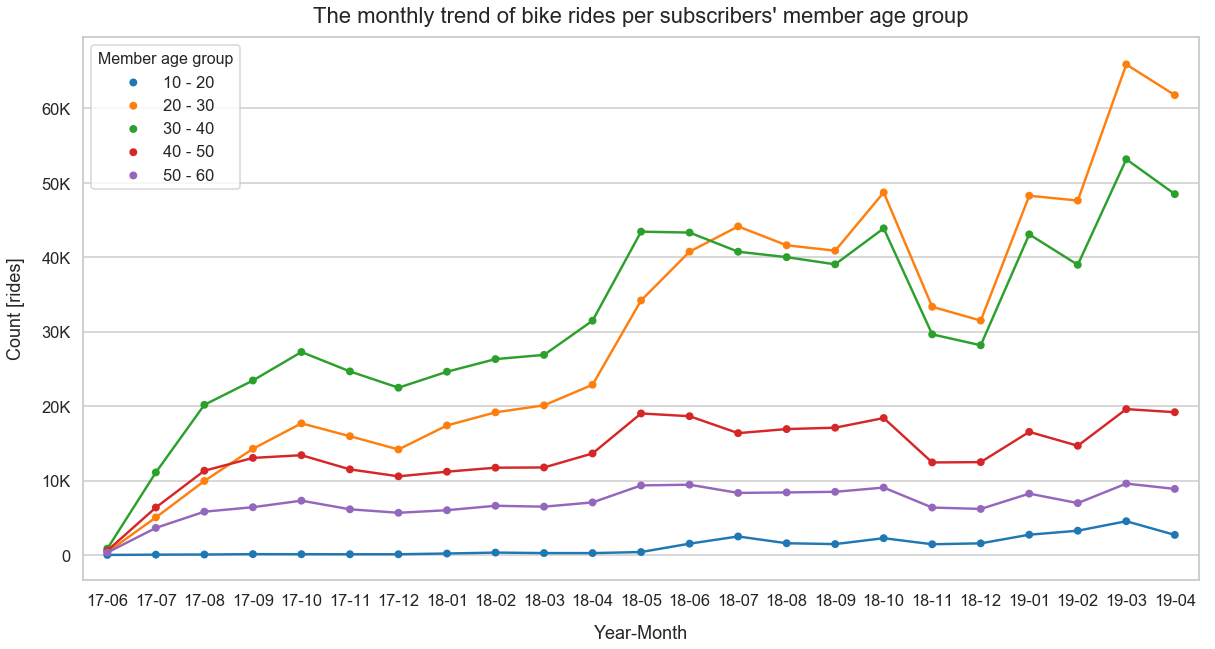

In [224]:
plt.figure(figsize=(20,10))
ax = sns.pointplot(x='start_time_year_month_renamed', y='bike_id', hue='member_age_bins', scale=.6, data=subscriber_age_df)
plt.title("The monthly trend of bike rides per subscribers' member age group", fontsize=22, y=1.015)
plt.xlabel('Year-Month', labelpad=16)
plt.ylabel('Count [rides]', labelpad=16)
leg = ax.legend()
leg.set_title('Member age group',prop={'size':16})
ax = plt.gca()
ax.yaxis.set_major_formatter(tick.FuncFormatter(transform_axis_fmt))
plt.savefig('image12.png');

#### Main purpose bike rides for subscribers and customers (20~40 years age group)

In [225]:
subscriber_hour_df = df[(df['member_age']>=20) & (df['member_age']<40) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [226]:
subscriber_hour_df['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [227]:
subscriber_hour_df['count_perc'] = subscriber_hour_df['count'].apply(lambda x: (x/subscriber_hour_df['count'].sum())*100)

In [228]:
subscriber_hour_df['rank'] = subscriber_hour_df['count_perc'].rank(ascending=False).astype(int)

In [229]:
subscriber_hour_df_pivoted = subscriber_hour_df.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

In [230]:
customer_hour_df = df[(df['member_age']>=20) & (df['member_age']<40) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Customer') 
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [231]:
customer_hour_df['start_time_weekday_abbr'] = pd.Categorical(customer_hour_df['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [232]:
customer_hour_df['count_perc'] = customer_hour_df['count'].apply(lambda x: (x/customer_hour_df['count'].sum())*100) #male

In [233]:
customer_hour_df['rank'] = customer_hour_df['count_perc'].rank(ascending=False).astype(int)

In [234]:
customer_hour_df_pivoted = customer_hour_df.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank').astype(int)

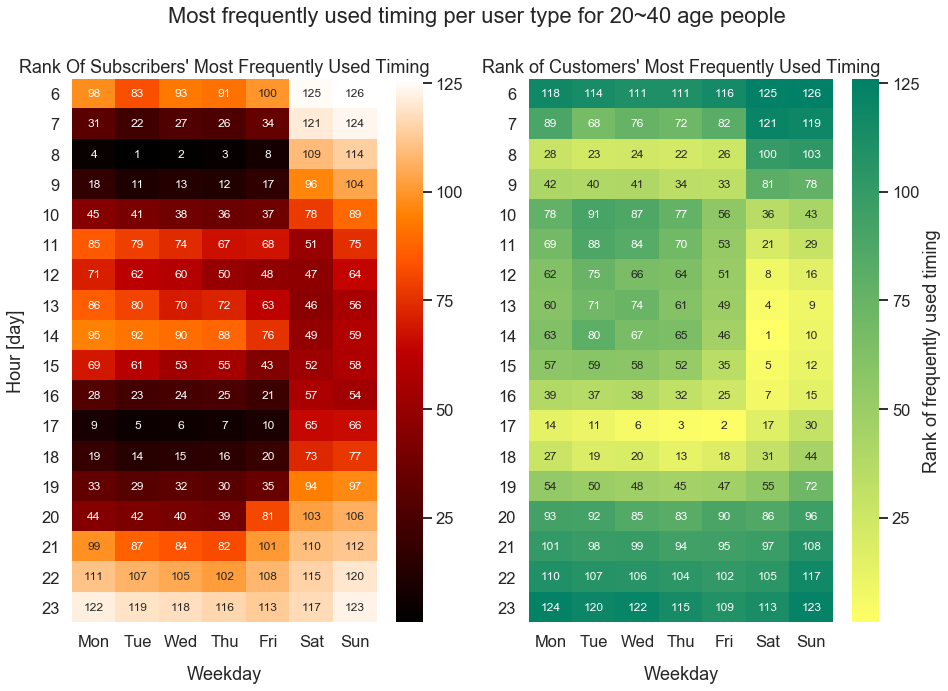

In [243]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.suptitle('Most frequently used timing per user type for 20~40 age people', fontsize=22)
sns.heatmap(subscriber_hour_df_pivoted, fmt='d', annot=True, cmap='gist_heat', annot_kws={"size": 12})
plt.title("Rank Of Subscribers' Most Frequently Used Timing", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel('Hour [day]', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(122)
sns.heatmap(customer_hour_df_pivoted, fmt='d', annot=True, cmap='summer_r', annot_kws={"size": 12}, cbar_kws={'label': 'Rank of frequently used timing'})
plt.title("Rank of Customers' Most Frequently Used Timing", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
plt.savefig('image13.png');

Subscribers are most frequently used this service around 7~9am and 4~6pm. Customers are used this service at weekend around 10am~5pm and weekday 5pm~6pm. Customers who use this service during weekend for leisure and weekdays after work.

#### Question 4. How is the trend of electric bike rides and which age group favors E-Bike?

Ford GoBike annouced the launch of electric bikes as April 24th, 2018. It can be implied that the new electric bikes were added in a week after April 24th.

Predict electric bike

In [244]:
non_electric_bike_id = df[df['start_time'] < pd.Timestamp(2018,4,24)]['bike_id'].unique()

In [245]:
electric_bike_id = []
for bike_id in df[(df['start_time'] > pd.Timestamp(2018, 4, 24)) & (df['start_time'] < pd.Timestamp(2018, 5, 24))]['bike_id']: 
    if bike_id not in non_electric_bike_id and bike_id not in electric_bike_id:
        electric_bike_id.append(bike_id)


In [246]:
len(electric_bike_id)

313

In [247]:
df['electric_bike_id'] = df['bike_id'].isin(electric_bike_id)

Number of electric bike rides vs regular bike rides for the first month

In [248]:
(df['electric_bike_id'].value_counts()/df['electric_bike_id'].value_counts().sum())*100

False    94.45362
True      5.54638
Name: electric_bike_id, dtype: float64

Verification of electric bikes with box plot for the first month

In [277]:
electric_bike_verification_df = df[(df['start_time']>pd.Timestamp(2018, 4, 24))&(df['start_time']<pd.Timestamp(2018, 5, 24))].groupby(['start_time_date','bike_id']).size().reset_index()

In [278]:
electric_bike_verification_df = electric_bike_verification_df.rename(columns={0:'count'})

In [279]:
electric_bike_verification_df['bike_type']=electric_bike_verification_df['bike_id'].apply(lambda x: 'electric' if x in electric_bike_id else 'non-electric')

In [280]:
electric_bike_verification_df['start_time_date'] = electric_bike_verification_df['start_time_date'].map(lambda x: x.strftime('%m-%d'))

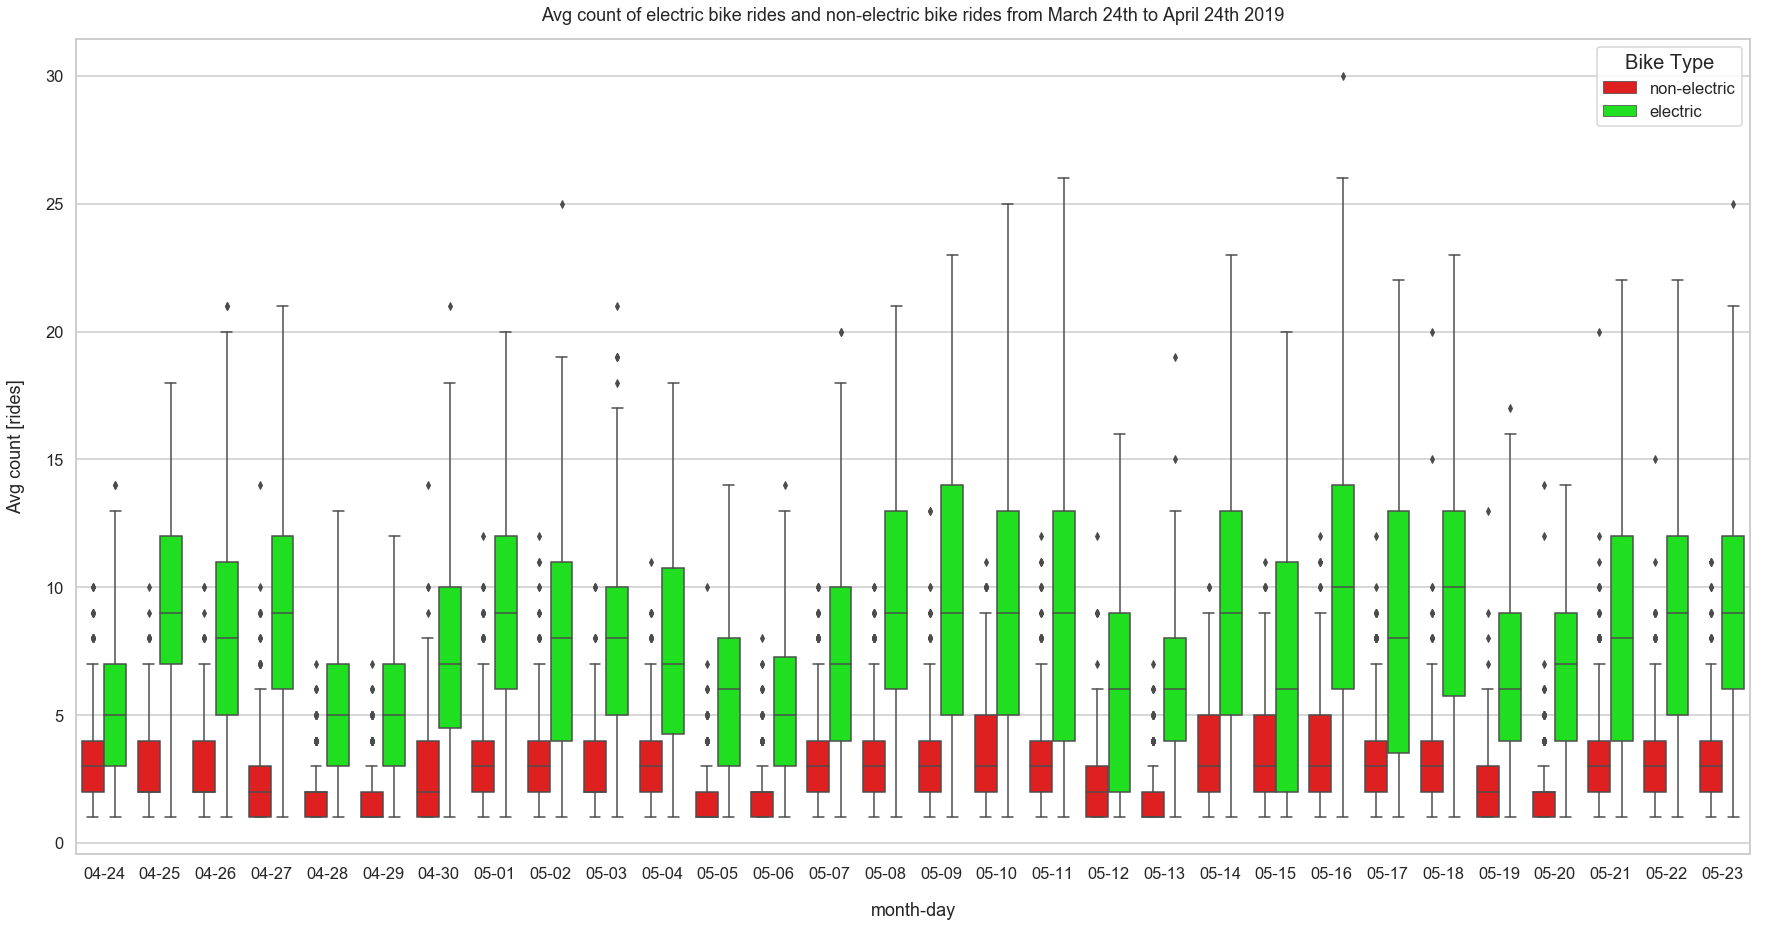

In [281]:
plt.figure(figsize=(30,15))
my_palette = {"electric":"lime", 'non-electric':'red'}
ax = sns.boxplot(x='start_time_date', y='count', hue='bike_type', linewidth=1.5, palette=my_palette, data=electric_bike_verification_df)
plt.title('Avg count of electric bike rides and non-electric bike rides from March 24th to April 24th 2019', y=1.015)
plt.xlabel('month-day', labelpad=20)
plt.ylabel('Avg count [rides]', labelpad=20)
leg = ax.legend()
leg.set_title('Bike Type',prop={'size':20})
plt.savefig('image16.png');

There is huge difference between electric bike and normal bike rides. After the news of new launch of electric bike service, there may be high demands on riding electric bikes.

Count of daily electric bike rides from April 24th 2018 to April 30th 2019

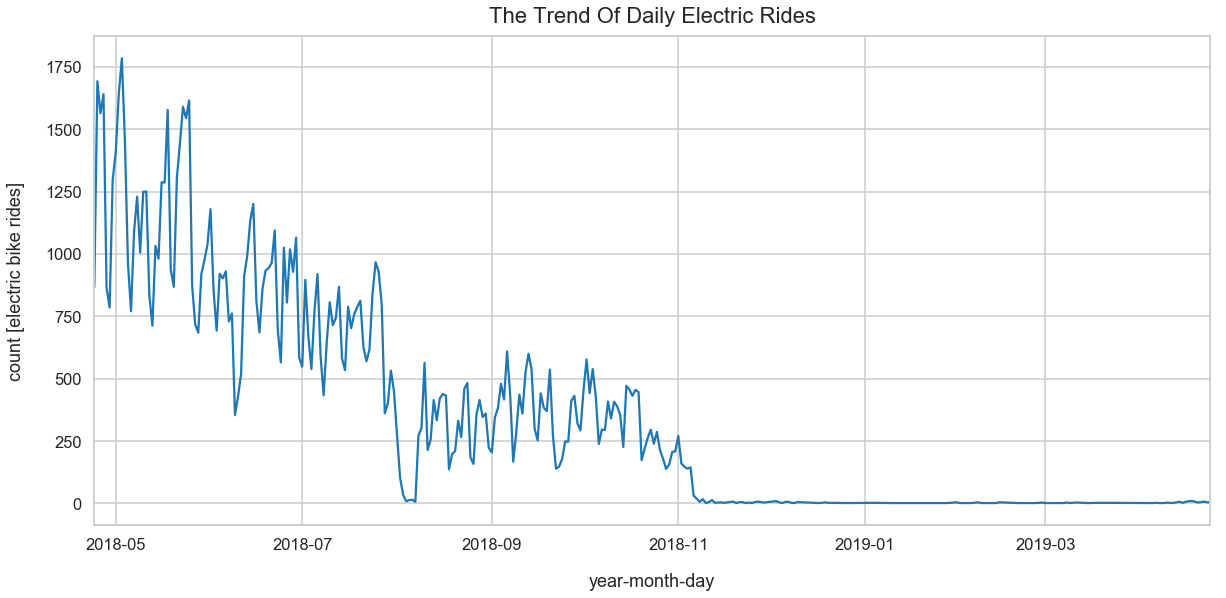

In [286]:
electric_df = df[df['electric_bike_id']==1].reset_index()
electric_df.groupby('start_time_date').agg({'bike_id':'count'}).plot(style='-', legend=False, figsize=(20,9))
plt.title('The Trend Of Daily Electric Rides', fontsize=22, y=1.015)
plt.xlabel('year-month-day', labelpad=20)
plt.ylabel('count [electric bike rides]', labelpad=20)
plt.savefig('image16.png');

Initially electric bike was very famous but it started declining with time and stopped at all in 11-2018.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

Percentage of subscribers is 12%. Percentage of customers is almost 88%.

Customers' rides seems increasing slightly. During the winter season the rides start declining every year. 
•	
Subscribers' average trip duration is around 11 minutes. Customers' average trip duration is around 28 minutes.
•	
Subscribers and customers trip distance were about the same, which is slightly more than one mile.
I selected the most popular group 20-40 years old people in order to compare hiring days, time of the day, peak times etc.
•	
Subscribers are most frequently used this service around 7~9am and 4~6pm. Customers are used this service at weekend around 10am~5pm and weekday 5pm~6pm. Customers use this service during weekend for leisure and weekdays after work.
•	
On the other hand, i checked the electrical bike program. Ford GoBike announced the launch of electric bikes as April 24th, 2018. 91.9% of rides are non-electric bike rides. Electric bike rides accounts for 8.1% of the total rides in the first month. It was increased suddenly at the beginning of the program launch. There is a huge spike at the end of April. After that, it seems the usage trend for electric bikes are decreasing and it ended in November 2018. 

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

I noticed that electric bikes were very famous in the begining and then it started decrease in demand rapidly.  Which tells that electric bikes were not successful.  

## Multivariate Exploration

I want to explore in this part of the analysis is how the three variables (Age group, weekdays, timeframe of subscribers) in relationship with hiring. Because, subscribers are more common and hiring partners of this program.

In [287]:
subscriber_hour_df2 = df[(df['member_age']>=20) & (df['member_age']<30) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [288]:
subscriber_hour_df3 = df[(df['member_age']>=30) & (df['member_age']<40) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [289]:
subscriber_hour_df4 = df[(df['member_age']>=40) & (df['member_age']<50) 
                              &(df['start_time_hour']>5)&(df['user_type']=='Subscriber')
                             ].groupby(['start_time_weekday_abbr', 'start_time_hour']).agg({'bike_id' : 'count'}).rename(columns={'bike_id':'count'}).reset_index()

In [290]:
subscriber_hour_df2['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_df2['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [291]:
subscriber_hour_df3['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_df3['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [292]:
subscriber_hour_df4['start_time_weekday_abbr'] = pd.Categorical(subscriber_hour_df4['start_time_weekday_abbr'], categories=['Mon','Tue','Wed','Thu','Fri','Sat', 'Sun'], ordered=True)

In [293]:
subscriber_hour_df2['count_perc'] = subscriber_hour_df2['count'].apply(lambda x: (x/subscriber_hour_df['count'].sum())*100)

In [294]:
subscriber_hour_df3['count_perc'] = subscriber_hour_df3['count'].apply(lambda x: (x/subscriber_hour_df['count'].sum())*100)

In [295]:
subscriber_hour_df4['count_perc'] = subscriber_hour_df4['count'].apply(lambda x: (x/subscriber_hour_df['count'].sum())*100)

In [296]:
subscriber_hour_df2['rank'] = subscriber_hour_df2['count_perc'].rank(ascending=False).astype(int)

In [297]:
subscriber_hour_df3['rank'] = subscriber_hour_df3['count_perc'].rank(ascending=False).astype(int)

In [298]:
subscriber_hour_df4['rank'] = subscriber_hour_df4['count_perc'].rank(ascending=False).astype(int)

In [299]:
subscriber_hour_df_pivoted2 = subscriber_hour_df2.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

In [300]:
subscriber_hour_df_pivoted3 = subscriber_hour_df3.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

In [301]:
subscriber_hour_df_pivoted4 = subscriber_hour_df4.pivot_table(index='start_time_hour', columns='start_time_weekday_abbr', values='rank')

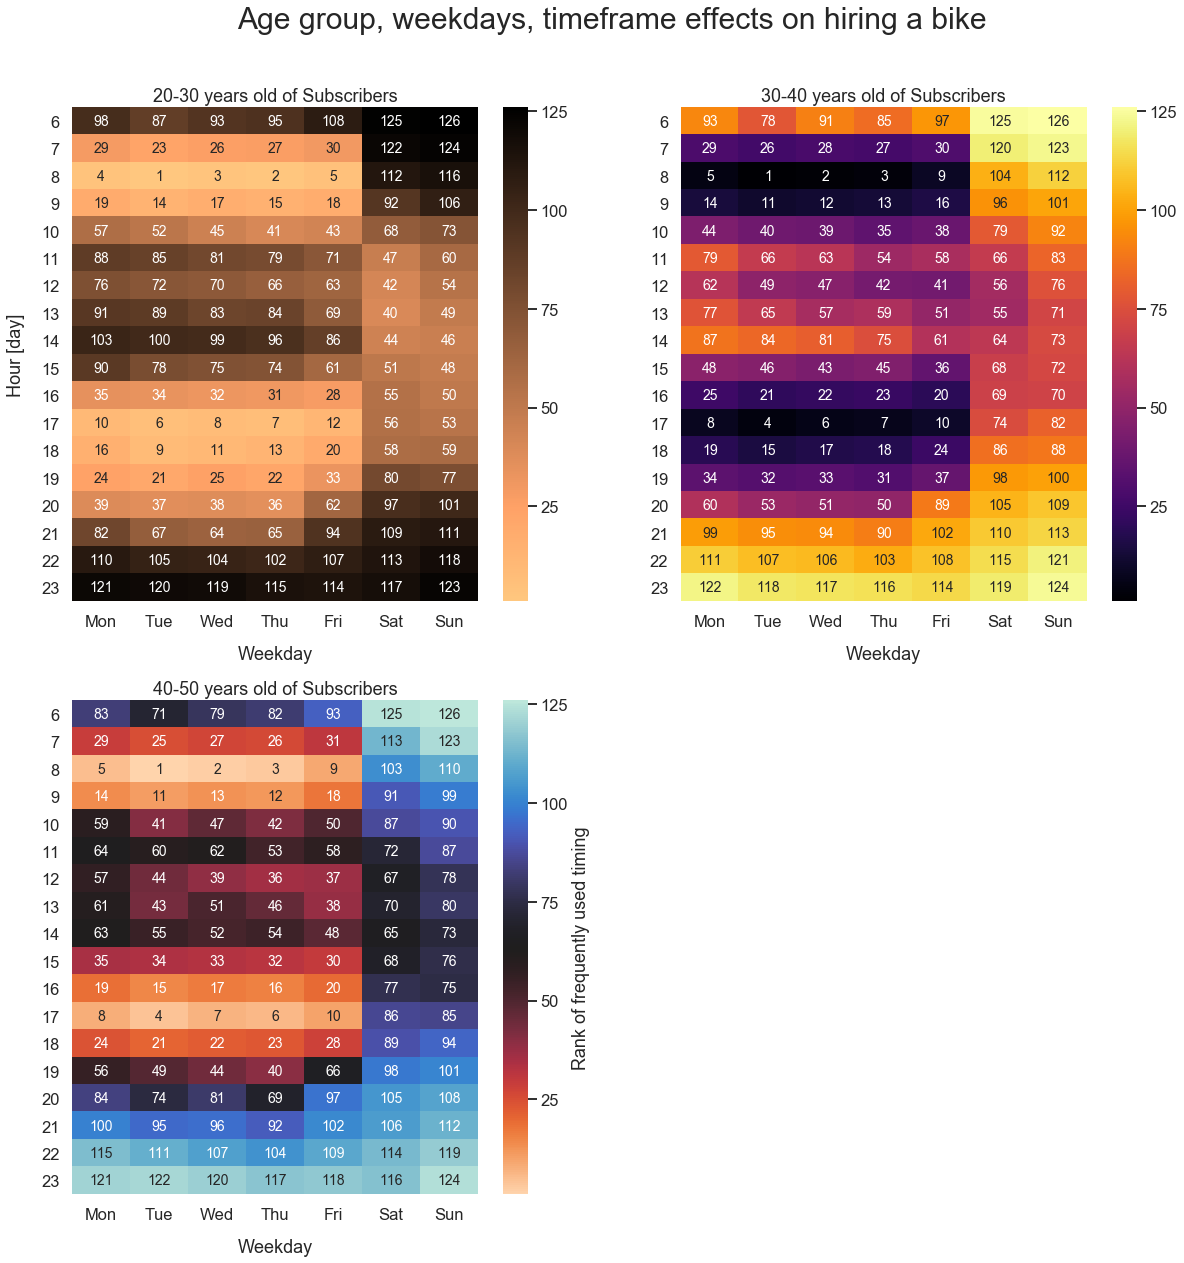

In [303]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.suptitle('Age group, weekdays, timeframe effects on hiring a bike', fontsize=30, y=0.95)
sns.heatmap(subscriber_hour_df_pivoted2, fmt='d', annot=True, cmap='copper_r', annot_kws={"size": 14})
plt.title("20-30 years old of Subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel('Hour [day]', labelpad=16)
plt.yticks(rotation=360)
plt.subplot(222)
sns.heatmap(subscriber_hour_df_pivoted3, fmt='d', annot=True, cmap='inferno', annot_kws={"size": 14})
plt.title("30-40 years old of Subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
plt.subplot(223)
sns.heatmap(subscriber_hour_df_pivoted4, fmt='d', annot=True, cmap='icefire_r', annot_kws={"size": 14}, cbar_kws={'label': 'Rank of frequently used timing'})
plt.title("40-50 years old of Subscribers", y=1.015)
plt.xlabel('Weekday', labelpad=16)
plt.ylabel(' ')
plt.yticks(rotation=360)
plt.savefig('image18.png');

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

I prolonged my investigation of bike hiring with 3 different variables such as age group, timeframe, weekday. The multivariate investigation here showed me that people who are older than the others have more time to drive a bike rather than a young people. 20-30 years old people are active and mostly use the bike for commute to and from work to home. Older age range bikers has more flexibility and they seem to be riding any time during the day where as younger riders rides during commute hours or lunch hours.

### Were there any interesting or surprising interactions between features?

It was surprising to see these many older age group people in this.  I was expecting lower number.  Also figures shows that they are active and they have flexible hours. 

There were 6.25 billion rides. 20-30 years old users are rapidly growing compared to other user groups. When the service first started 30-40 years old users were dominant, and eventually with time as the service became more popular the 20-30 years old users became leader in a year. 20 to 40 years old people took the more than %70 of bike rides.  Among those, 30 to 40 years old people's rides account almost 40% of all bike rides. Male took around 76% of all bike rides, and female took around 24% of them. People use this service on weekdays more than weekends. 8am and 5pm are the peak hours for this service. Also, people use this service when they are in lunch time as well. Percentage of customers is almost 88. Percentage of subscribers is 12%. During the winter months of November, December and part of January, there is a drastic decrease in riders. Subscribers' average trip duration is around 11 minutes. Customers' average trip duration is around 28 minutes. Subscribers and customers trip distance were about the same, which is slightly more than one mile. 90% of bike rides take place on weekday. The peak bike rides time for all members is around commute time.
After Ford GoBike did a pilot launch of e-bike on April 24th 2018, there was substantial increase in electric bike riders but then it started declining rapidly and then the electric bike service stopped in November 2018.
